# Lab 2 Iterative Algorithm Design
## Authors: Nigel Nelson, Collin Quinn
### Course: CS-3851


---

### Imports:

In [33]:
import time
import matplotlib.pyplot as plt
import math
import random
from typing import List
from typing import Tuple

### Functions responsible for determining if a point is within a specified polygon:

In [34]:
def is_inside(points, target):
    """
    Determines if the target point is contained within a polygon which is
    represented as a list of vertices.
    :param points: A list of tuples representing a polygon's vertices 
    :param target: A tuple representing a point
    :return: Whether the target point is within the polygon
    """
    num_intersects = 0
    # Add 1 to the largest x coordinate instead of using infinity
    # to avoid NANs
    furthest_x = max(points)[0] + 1
    right_point = (furthest_x, target[1])
    # Add the first vertex to the points so that each line segment
    # is checked for intersections
    points.append(points[0])
    for i in range(0, len(points) - 1):
        point1 = points[i]
        point2 = points[i+1]
        if do_intersect(point1, point2, target, right_point):
            num_intersects += 1
            # Short circuit and return true if the target is on the line segment
            if located_on_line(point1, point2, target):
                return True
    return num_intersects % 2 != 0

def do_intersect(pointA, pointB, pointC, pointD):
    """
    Determines if two line segments, represented by pointA to pointB and
    pointC to pointD, intersect if the line represented by pointC and pointD
    was extended to the right.
    :param pointA: A tuple representing a point
    :param pointB: A tuple representing a point
    :param pointC: A tuple representing a point
    :param pointD: A tuple representing a point
    :return: Whether the line segments intersect
    """
    a1 = pointB[1] - pointA[1]
    b1 = pointA[0] - pointB[0]
    c1 = a1 * (pointA[0]) + b1 * (pointA[1])
    a2 = pointD[1] - pointC[1]
    b2 = pointC[0] - pointD[0]
    c2 = a2 * (pointC[0]) + b2 * (pointC[1])
    determinant = a1 * b2 - a2 * b1
    # Determine if the lines are parallel 
    if (determinant == 0):
        return False
    else:
        # Determine x and y coordinates of the intersection
        x = (c1*b2 - c2*b1)/determinant
        y = (a1*c2 - a2*c1)/determinant
        # Ensure its a valid point
        isValidX = min(pointA[0], pointB[0]) <= x <= max(pointA[0], pointB[0])
        isValidY = min(pointA[1], pointB[1]) <= y <= max(pointA[1], pointB[1])
        # Ensure the insection is to the right of the target point
        isToRight = x >= pointC[0]

        return isValidX and isValidY and isToRight


def located_on_line(pointA, pointB, target):
    """
    Determines if the target point lies on a line segment represented
    by pointA and pointB
    :param pointA: A tuple representing a point
    :param pointB: A tuple representing a point
    :param target: a tuple representing a point
    :return: Whether target lies on the line segment
    """
    if ((target[0] <= max(pointA[0], pointB[0]))
            & (target[0] >= min(pointA[0], pointB[0]))
            & (target[1] <= max(pointA[1], pointB[1]))
            & (target[1] >= min(pointA[1], pointB[1]))):
        return True
    return False

In [35]:
polygon1 = [(0, 0), (10, 0), (10, 10), (0, 10)]

p1 = (20, 20)  # false
p2 = (5, 5)  # true
p3 = (-23, -23)  # false
p4 = (0, 3)  # true

polygon2 = [(0, 0), (5, 0), (5, 5), (3, 3)]

p5 = (3, 3)  # true
p6 = (5, 1)  # true
p7 = (8, 1)  # false
p8 = (2.4, 0) # true

In [36]:
print(is_inside(polygon1, p1))
print(is_inside(polygon1, p2))
print(is_inside(polygon1, p3))
print(is_inside(polygon1, p4))
print(is_inside(polygon2, p5))
print(is_inside(polygon2, p6))
print(is_inside(polygon2, p7))
print(is_inside(polygon2, p8))

False
True
False
True
True
True
False
True


## Function responsible for creating random polygons with a specified number of vertices:
- Credit for the code in the below cell belongs to Mike Ounsworth, a member of Stack Overflow.
- [Link to Mike's Stack Overflow answer](https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon)

In [37]:
def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * math.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(num_vertices):
        radius = clip(random.gauss(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * math.cos(angle),
                 center[1] + radius * math.sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points

def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * math.pi / steps) - irregularity
    upper = (2 * math.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * math.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles

def clip(value, lower, upper):
    """
    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))

In [39]:
def benchmark(algorithm, points, target):
    start_time = time.perf_counter()
    algorithm(points, target)
    end_time = time.perf_counter()
    return end_time - start_time

In [38]:
list_sizes = [10, 100, 1000, 10000, 100000, 1000000]
polygon_center = (0,0)
run_times = []

for size in list_sizes:
    points = generate_polygon(center=polygon_center,
                                avg_radius=100,
                                irregularity=0.35,
                                spikiness=0.2,
                                num_vertices=size)
    total_time = benchmark(is_inside, points, polygon_center)
    run_times.append(total_time)

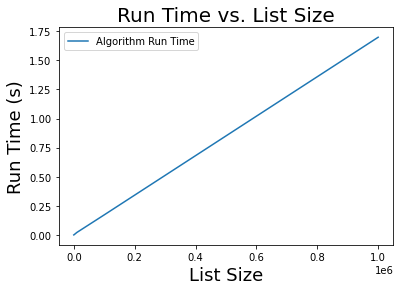

In [41]:
plt.plot(list_sizes, run_times, label="Algorithm Run Time")
plt.xlabel("List Size", fontsize=18)
plt.ylabel("Run Time (s)", fontsize=18)
plt.title("Run Time vs. List Size", fontsize=20)
plt.legend()